# Use PPO to Play Acrobot-v1

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import scipy.signal as signal
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
torch.manual_seed(0)

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Acrobot-v1')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

22:56:35 [INFO] env: <AcrobotEnv<Acrobot-v1>>
22:56:35 [INFO] action_space: Discrete(3)
22:56:35 [INFO] observation_space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
22:56:35 [INFO] reward_range: (-inf, inf)
22:56:35 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 15}
22:56:35 [INFO] _max_episode_steps: 500
22:56:35 [INFO] _elapsed_steps: None


In [3]:
class PPOReplayer:
    def __init__(self):
        self.fields = ['state', 'action', 'prob', 'advantage', 'return']
        self.memory = pd.DataFrame(columns=self.fields)

    def store(self, df):
        self.memory = pd.concat([self.memory, df[self.fields]], ignore_index=True)

    def sample(self, size):
        indices = np.random.choice(self.memory.shape[0], size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class PPOAgent:
    def __init__(self, env):
        self.gamma = 0.99

        self.replayer = PPOReplayer()

        self.actor_net = self.build_network(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,],
                output_size=env.action_space.n, output_activator=nn.Softmax(1))
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), 0.001)
        self.critic_net = self.build_network(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,])
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), 0.002)
        self.critic_loss = nn.MSELoss()

    def build_network(self, input_size, hidden_sizes, output_size=1,
            output_activator=None):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
        prob_tensor = self.actor_net(state_tensor)
        action_tensor = distributions.Categorical(prob_tensor).sample()
        action = action_tensor.numpy()[0]
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
        return action

    def close(self):
        if self.mode == 'train':
            self.save_trajectory_to_replayer()
            if len(self.replayer.memory) >= 1000:
                for batch in range(5): # learn multiple times
                    self.learn()
                self.replayer = PPOReplayer() # reset replayer after the agent changes itself

    def save_trajectory_to_replayer(self):
        df = pd.DataFrame(
                np.array(self.trajectory, dtype=object).reshape(-1, 4),
                columns=['state', 'reward', 'done', 'action'])
        state_tensor = torch.as_tensor(np.stack(df['state']), dtype=torch.float)
        action_tensor = torch.as_tensor(df['action'], dtype=torch.long)
        v_tensor = self.critic_net(state_tensor)
        df['v'] = v_tensor.detach().numpy()
        prob_tensor = self.actor_net(state_tensor)
        pi_tensor = prob_tensor.gather(-1, action_tensor.unsqueeze(1)).squeeze(1)
        df['prob'] = pi_tensor.detach().numpy()
        df['next_v'] = df['v'].shift(-1).fillna(0.)
        df['u'] = df['reward'] + self.gamma * df['next_v']
        df['delta'] = df['u'] - df['v']
        df['advantage'] = signal.lfilter([1.,], [1., -self.gamma],
                df['delta'][::-1])[::-1]
        df['return'] = signal.lfilter([1.,], [1., -self.gamma],
                df['reward'][::-1])[::-1]
        self.replayer.store(df)

    def learn(self):
        states, actions, old_pis, advantages, returns = \
                self.replayer.sample(size=64)
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.long)
        old_pi_tensor = torch.as_tensor(old_pis, dtype=torch.float)
        advantage_tensor = torch.as_tensor(advantages, dtype=torch.float)
        return_tensor = torch.as_tensor(returns, dtype=torch.float).unsqueeze(1)

        # train actor net
        all_pi_tensor = self.actor_net(state_tensor)
        pi_tensor = all_pi_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
        surrogate_advantage_tensor = (pi_tensor / old_pi_tensor) * \
                advantage_tensor
        clip_times_advantage_tensor = 0.1 * surrogate_advantage_tensor
        max_surrogate_advantage_tensor = advantage_tensor + \
                torch.where(advantage_tensor > 0.,
                clip_times_advantage_tensor, -clip_times_advantage_tensor)
        clipped_surrogate_advantage_tensor = torch.min(
                surrogate_advantage_tensor, max_surrogate_advantage_tensor)
        actor_loss_tensor = -clipped_surrogate_advantage_tensor.mean()
        self.actor_optimizer.zero_grad()
        actor_loss_tensor.backward()
        self.actor_optimizer.step()

        # train critic net
        pred_tensor = self.critic_net(state_tensor)
        critic_loss_tensor = self.critic_loss(pred_tensor, return_tensor)
        self.critic_optimizer.zero_grad()
        critic_loss_tensor.backward()
        self.critic_optimizer.step()


agent = PPOAgent(env)

22:56:35 [INFO] ==== train ====
22:56:36 [INFO] NumExpr defaulting to 8 threads.
22:56:36 [DEBUG] train episode 0: reward = -500.00, steps = 500
22:56:37 [DEBUG] train episode 1: reward = -500.00, steps = 500
22:56:38 [DEBUG] train episode 2: reward = -500.00, steps = 500
22:56:40 [DEBUG] train episode 3: reward = -500.00, steps = 500
22:56:41 [DEBUG] train episode 4: reward = -500.00, steps = 500
22:56:42 [DEBUG] train episode 5: reward = -500.00, steps = 500
22:56:43 [DEBUG] train episode 6: reward = -500.00, steps = 500
22:56:45 [DEBUG] train episode 7: reward = -500.00, steps = 500
22:56:46 [DEBUG] train episode 8: reward = -500.00, steps = 500
22:56:47 [DEBUG] train episode 9: reward = -500.00, steps = 500
22:56:48 [DEBUG] train episode 10: reward = -500.00, steps = 500
22:56:50 [DEBUG] train episode 11: reward = -500.00, steps = 500
22:56:51 [DEBUG] train episode 12: reward = -500.00, steps = 500
22:56:52 [DEBUG] train episode 13: reward = -500.00, steps = 500
22:56:53 [DEBUG] tr

22:58:18 [DEBUG] train episode 125: reward = -165.00, steps = 166
22:58:18 [DEBUG] train episode 126: reward = -268.00, steps = 269
22:58:18 [DEBUG] train episode 127: reward = -272.00, steps = 273
22:58:19 [DEBUG] train episode 128: reward = -207.00, steps = 208
22:58:19 [DEBUG] train episode 129: reward = -218.00, steps = 219
22:58:19 [DEBUG] train episode 130: reward = -188.00, steps = 189
22:58:20 [DEBUG] train episode 131: reward = -187.00, steps = 188
22:58:20 [DEBUG] train episode 132: reward = -301.00, steps = 302
22:58:21 [DEBUG] train episode 133: reward = -236.00, steps = 237
22:58:21 [DEBUG] train episode 134: reward = -368.00, steps = 369
22:58:21 [DEBUG] train episode 135: reward = -199.00, steps = 200
22:58:22 [DEBUG] train episode 136: reward = -394.00, steps = 395
22:58:22 [DEBUG] train episode 137: reward = -211.00, steps = 212
22:58:23 [DEBUG] train episode 138: reward = -182.00, steps = 183
22:58:23 [DEBUG] train episode 139: reward = -257.00, steps = 258
22:58:23 [

22:59:02 [DEBUG] train episode 250: reward = -251.00, steps = 252
22:59:02 [DEBUG] train episode 251: reward = -178.00, steps = 179
22:59:02 [DEBUG] train episode 252: reward = -176.00, steps = 177
22:59:02 [DEBUG] train episode 253: reward = -224.00, steps = 225
22:59:03 [DEBUG] train episode 254: reward = -136.00, steps = 137
22:59:03 [DEBUG] train episode 255: reward = -159.00, steps = 160
22:59:03 [DEBUG] train episode 256: reward = -166.00, steps = 167
22:59:03 [DEBUG] train episode 257: reward = -132.00, steps = 133
22:59:04 [DEBUG] train episode 258: reward = -251.00, steps = 252
22:59:04 [DEBUG] train episode 259: reward = -254.00, steps = 255
22:59:04 [DEBUG] train episode 260: reward = -151.00, steps = 152
22:59:04 [DEBUG] train episode 261: reward = -145.00, steps = 146
22:59:05 [DEBUG] train episode 262: reward = -214.00, steps = 215
22:59:05 [DEBUG] train episode 263: reward = -206.00, steps = 207
22:59:05 [DEBUG] train episode 264: reward = -174.00, steps = 175
22:59:05 [

22:59:34 [DEBUG] train episode 375: reward = -155.00, steps = 156
22:59:34 [DEBUG] train episode 376: reward = -229.00, steps = 230
22:59:35 [DEBUG] train episode 377: reward = -178.00, steps = 179
22:59:35 [DEBUG] train episode 378: reward = -188.00, steps = 189
22:59:35 [DEBUG] train episode 379: reward = -150.00, steps = 151
22:59:35 [DEBUG] train episode 380: reward = -282.00, steps = 283
22:59:36 [DEBUG] train episode 381: reward = -160.00, steps = 161
22:59:36 [DEBUG] train episode 382: reward = -229.00, steps = 230
22:59:36 [DEBUG] train episode 383: reward = -177.00, steps = 178
22:59:36 [DEBUG] train episode 384: reward = -246.00, steps = 247
22:59:37 [DEBUG] train episode 385: reward = -215.00, steps = 216
22:59:37 [DEBUG] train episode 386: reward = -170.00, steps = 171
22:59:37 [DEBUG] train episode 387: reward = -195.00, steps = 196
22:59:37 [DEBUG] train episode 388: reward = -192.00, steps = 193
22:59:38 [DEBUG] train episode 389: reward = -168.00, steps = 169
22:59:38 [

23:00:04 [DEBUG] train episode 500: reward = -193.00, steps = 194
23:00:04 [DEBUG] train episode 501: reward = -194.00, steps = 195
23:00:04 [DEBUG] train episode 502: reward = -138.00, steps = 139
23:00:05 [DEBUG] train episode 503: reward = -249.00, steps = 250
23:00:05 [DEBUG] train episode 504: reward = -289.00, steps = 290
23:00:05 [DEBUG] train episode 505: reward = -241.00, steps = 242
23:00:05 [DEBUG] train episode 506: reward = -132.00, steps = 133
23:00:05 [DEBUG] train episode 507: reward = -150.00, steps = 151
23:00:06 [DEBUG] train episode 508: reward = -176.00, steps = 177
23:00:06 [DEBUG] train episode 509: reward = -225.00, steps = 226
23:00:06 [DEBUG] train episode 510: reward = -261.00, steps = 262
23:00:06 [DEBUG] train episode 511: reward = -155.00, steps = 156
23:00:07 [DEBUG] train episode 512: reward = -159.00, steps = 160
23:00:07 [DEBUG] train episode 513: reward = -172.00, steps = 173
23:00:07 [DEBUG] train episode 514: reward = -165.00, steps = 166
23:00:07 [

23:00:30 [DEBUG] train episode 625: reward = -201.00, steps = 202
23:00:30 [DEBUG] train episode 626: reward = -210.00, steps = 211
23:00:30 [DEBUG] train episode 627: reward = -140.00, steps = 141
23:00:30 [DEBUG] train episode 628: reward = -158.00, steps = 159
23:00:31 [DEBUG] train episode 629: reward = -137.00, steps = 138
23:00:31 [DEBUG] train episode 630: reward = -236.00, steps = 237
23:00:31 [DEBUG] train episode 631: reward = -172.00, steps = 173
23:00:31 [DEBUG] train episode 632: reward = -297.00, steps = 298
23:00:32 [DEBUG] train episode 633: reward = -126.00, steps = 127
23:00:32 [DEBUG] train episode 634: reward = -172.00, steps = 173
23:00:32 [DEBUG] train episode 635: reward = -253.00, steps = 254
23:00:32 [DEBUG] train episode 636: reward = -202.00, steps = 203
23:00:32 [DEBUG] train episode 637: reward = -203.00, steps = 204
23:00:33 [DEBUG] train episode 638: reward = -179.00, steps = 180
23:00:33 [DEBUG] train episode 639: reward = -169.00, steps = 170
23:00:33 [

23:00:55 [DEBUG] train episode 750: reward = -158.00, steps = 159
23:00:55 [DEBUG] train episode 751: reward = -235.00, steps = 236
23:00:55 [DEBUG] train episode 752: reward = -160.00, steps = 161
23:00:56 [DEBUG] train episode 753: reward = -183.00, steps = 184
23:00:56 [DEBUG] train episode 754: reward = -181.00, steps = 182
23:00:56 [DEBUG] train episode 755: reward = -167.00, steps = 168
23:00:56 [DEBUG] train episode 756: reward = -181.00, steps = 182
23:00:57 [DEBUG] train episode 757: reward = -500.00, steps = 500
23:00:57 [DEBUG] train episode 758: reward = -178.00, steps = 179
23:00:57 [DEBUG] train episode 759: reward = -154.00, steps = 155
23:00:57 [DEBUG] train episode 760: reward = -176.00, steps = 177
23:00:58 [DEBUG] train episode 761: reward = -221.00, steps = 222
23:00:58 [DEBUG] train episode 762: reward = -145.00, steps = 146
23:00:58 [DEBUG] train episode 763: reward = -175.00, steps = 176
23:00:58 [DEBUG] train episode 764: reward = -135.00, steps = 136
23:00:58 [

23:01:19 [DEBUG] train episode 875: reward = -199.00, steps = 200
23:01:19 [DEBUG] train episode 876: reward = -219.00, steps = 220
23:01:19 [DEBUG] train episode 877: reward = -171.00, steps = 172
23:01:19 [DEBUG] train episode 878: reward = -147.00, steps = 148
23:01:19 [DEBUG] train episode 879: reward = -232.00, steps = 233
23:01:20 [DEBUG] train episode 880: reward = -148.00, steps = 149
23:01:20 [DEBUG] train episode 881: reward = -139.00, steps = 140
23:01:20 [DEBUG] train episode 882: reward = -226.00, steps = 227
23:01:20 [DEBUG] train episode 883: reward = -151.00, steps = 152
23:01:20 [DEBUG] train episode 884: reward = -205.00, steps = 206
23:01:20 [DEBUG] train episode 885: reward = -124.00, steps = 125
23:01:21 [DEBUG] train episode 886: reward = -197.00, steps = 198
23:01:21 [DEBUG] train episode 887: reward = -211.00, steps = 212
23:01:21 [DEBUG] train episode 888: reward = -165.00, steps = 166
23:01:21 [DEBUG] train episode 889: reward = -172.00, steps = 173
23:01:21 [

23:01:41 [DEBUG] train episode 1000: reward = -158.00, steps = 159
23:01:41 [DEBUG] train episode 1001: reward = -212.00, steps = 213
23:01:42 [DEBUG] train episode 1002: reward = -155.00, steps = 156
23:01:42 [DEBUG] train episode 1003: reward = -240.00, steps = 241
23:01:42 [DEBUG] train episode 1004: reward = -143.00, steps = 144
23:01:42 [DEBUG] train episode 1005: reward = -262.00, steps = 263
23:01:42 [DEBUG] train episode 1006: reward = -181.00, steps = 182
23:01:43 [DEBUG] train episode 1007: reward = -172.00, steps = 173
23:01:43 [DEBUG] train episode 1008: reward = -319.00, steps = 320
23:01:43 [DEBUG] train episode 1009: reward = -143.00, steps = 144
23:01:43 [DEBUG] train episode 1010: reward = -167.00, steps = 168
23:01:43 [DEBUG] train episode 1011: reward = -151.00, steps = 152
23:01:44 [DEBUG] train episode 1012: reward = -220.00, steps = 221
23:01:44 [DEBUG] train episode 1013: reward = -402.00, steps = 403
23:01:44 [DEBUG] train episode 1014: reward = -278.00, steps =

23:02:05 [DEBUG] train episode 1123: reward = -141.00, steps = 142
23:02:05 [DEBUG] train episode 1124: reward = -185.00, steps = 186
23:02:05 [DEBUG] train episode 1125: reward = -177.00, steps = 178
23:02:05 [DEBUG] train episode 1126: reward = -186.00, steps = 187
23:02:06 [DEBUG] train episode 1127: reward = -168.00, steps = 169
23:02:06 [DEBUG] train episode 1128: reward = -164.00, steps = 165
23:02:06 [DEBUG] train episode 1129: reward = -172.00, steps = 173
23:02:06 [DEBUG] train episode 1130: reward = -155.00, steps = 156
23:02:06 [DEBUG] train episode 1131: reward = -176.00, steps = 177
23:02:06 [DEBUG] train episode 1132: reward = -152.00, steps = 153
23:02:07 [DEBUG] train episode 1133: reward = -175.00, steps = 176
23:02:07 [DEBUG] train episode 1134: reward = -173.00, steps = 174
23:02:07 [DEBUG] train episode 1135: reward = -217.00, steps = 218
23:02:07 [DEBUG] train episode 1136: reward = -146.00, steps = 147
23:02:07 [DEBUG] train episode 1137: reward = -170.00, steps =

23:02:27 [DEBUG] train episode 1246: reward = -126.00, steps = 127
23:02:27 [DEBUG] train episode 1247: reward = -183.00, steps = 184
23:02:28 [DEBUG] train episode 1248: reward = -171.00, steps = 172
23:02:28 [DEBUG] train episode 1249: reward = -140.00, steps = 141
23:02:28 [DEBUG] train episode 1250: reward = -166.00, steps = 167
23:02:28 [DEBUG] train episode 1251: reward = -192.00, steps = 193
23:02:28 [DEBUG] train episode 1252: reward = -277.00, steps = 278
23:02:29 [DEBUG] train episode 1253: reward = -179.00, steps = 180
23:02:29 [DEBUG] train episode 1254: reward = -123.00, steps = 124
23:02:29 [DEBUG] train episode 1255: reward = -177.00, steps = 178
23:02:29 [DEBUG] train episode 1256: reward = -189.00, steps = 190
23:02:29 [DEBUG] train episode 1257: reward = -171.00, steps = 172
23:02:29 [DEBUG] train episode 1258: reward = -164.00, steps = 165
23:02:30 [DEBUG] train episode 1259: reward = -227.00, steps = 228
23:02:30 [DEBUG] train episode 1260: reward = -134.00, steps =

23:02:48 [DEBUG] train episode 1369: reward = -142.00, steps = 143
23:02:48 [DEBUG] train episode 1370: reward = -142.00, steps = 143
23:02:48 [DEBUG] train episode 1371: reward = -168.00, steps = 169
23:02:49 [DEBUG] train episode 1372: reward = -180.00, steps = 181
23:02:49 [DEBUG] train episode 1373: reward = -133.00, steps = 134
23:02:49 [DEBUG] train episode 1374: reward = -207.00, steps = 208
23:02:49 [DEBUG] train episode 1375: reward = -178.00, steps = 179
23:02:49 [DEBUG] train episode 1376: reward = -151.00, steps = 152
23:02:49 [DEBUG] train episode 1377: reward = -115.00, steps = 116
23:02:50 [DEBUG] train episode 1378: reward = -159.00, steps = 160
23:02:50 [DEBUG] train episode 1379: reward = -150.00, steps = 151
23:02:50 [DEBUG] train episode 1380: reward = -110.00, steps = 111
23:02:50 [DEBUG] train episode 1381: reward = -117.00, steps = 118
23:02:50 [DEBUG] train episode 1382: reward = -135.00, steps = 136
23:02:50 [DEBUG] train episode 1383: reward = -180.00, steps =

23:03:09 [DEBUG] train episode 1492: reward = -135.00, steps = 136
23:03:09 [DEBUG] train episode 1493: reward = -152.00, steps = 153
23:03:09 [DEBUG] train episode 1494: reward = -149.00, steps = 150
23:03:10 [DEBUG] train episode 1495: reward = -162.00, steps = 163
23:03:10 [DEBUG] train episode 1496: reward = -152.00, steps = 153
23:03:10 [DEBUG] train episode 1497: reward = -160.00, steps = 161
23:03:10 [DEBUG] train episode 1498: reward = -143.00, steps = 144
23:03:10 [DEBUG] train episode 1499: reward = -171.00, steps = 172
23:03:10 [DEBUG] train episode 1500: reward = -141.00, steps = 142
23:03:11 [DEBUG] train episode 1501: reward = -174.00, steps = 175
23:03:11 [DEBUG] train episode 1502: reward = -168.00, steps = 169
23:03:11 [DEBUG] train episode 1503: reward = -149.00, steps = 150
23:03:11 [DEBUG] train episode 1504: reward = -141.00, steps = 142
23:03:11 [DEBUG] train episode 1505: reward = -108.00, steps = 109
23:03:11 [DEBUG] train episode 1506: reward = -119.00, steps =

23:03:29 [DEBUG] train episode 1615: reward = -125.00, steps = 126
23:03:29 [DEBUG] train episode 1616: reward = -112.00, steps = 113
23:03:29 [DEBUG] train episode 1617: reward = -128.00, steps = 129
23:03:29 [DEBUG] train episode 1618: reward = -112.00, steps = 113
23:03:30 [DEBUG] train episode 1619: reward = -123.00, steps = 124
23:03:30 [DEBUG] train episode 1620: reward = -133.00, steps = 134
23:03:30 [DEBUG] train episode 1621: reward = -242.00, steps = 243
23:03:30 [DEBUG] train episode 1622: reward = -184.00, steps = 185
23:03:30 [DEBUG] train episode 1623: reward = -170.00, steps = 171
23:03:30 [DEBUG] train episode 1624: reward = -161.00, steps = 162
23:03:31 [DEBUG] train episode 1625: reward = -132.00, steps = 133
23:03:31 [DEBUG] train episode 1626: reward = -127.00, steps = 128
23:03:31 [DEBUG] train episode 1627: reward = -137.00, steps = 138
23:03:31 [DEBUG] train episode 1628: reward = -140.00, steps = 141
23:03:31 [DEBUG] train episode 1629: reward = -115.00, steps =

23:04:02 [DEBUG] test episode 65: reward = -124.00, steps = 125
23:04:02 [DEBUG] test episode 66: reward = -96.00, steps = 97
23:04:02 [DEBUG] test episode 67: reward = -128.00, steps = 129
23:04:03 [DEBUG] test episode 68: reward = -121.00, steps = 122
23:04:03 [DEBUG] test episode 69: reward = -152.00, steps = 153
23:04:03 [DEBUG] test episode 70: reward = -151.00, steps = 152
23:04:03 [DEBUG] test episode 71: reward = -104.00, steps = 105
23:04:03 [DEBUG] test episode 72: reward = -123.00, steps = 124
23:04:03 [DEBUG] test episode 73: reward = -98.00, steps = 99
23:04:03 [DEBUG] test episode 74: reward = -95.00, steps = 96
23:04:03 [DEBUG] test episode 75: reward = -122.00, steps = 123
23:04:03 [DEBUG] test episode 76: reward = -135.00, steps = 136
23:04:03 [DEBUG] test episode 77: reward = -148.00, steps = 149
23:04:03 [DEBUG] test episode 78: reward = -124.00, steps = 125
23:04:04 [DEBUG] test episode 79: reward = -125.00, steps = 126
23:04:04 [DEBUG] test episode 80: reward = -17

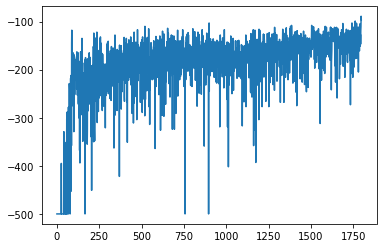

In [5]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -120:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [6]:
env.close()